# Practice 3: B-mode image reconstruction

Previously, we have seen how to emit a transmit wave, and analyse the presence of scatterings based on the received radiofrequency signal. Even if we can clearly see isolated scatterers in the signal, in the real case there are many scatterers, and thus the signal will be difficult to visualise. For this, an image representation is better.

In this session, we will focus on how to form an image form the radiofrequency signals. The image will be white and black, where the white pixels correspond to the reflectors in the space, and the black pixels correspond to the absence of reflectors. This requires locating the position of the reflectors in the space, based on the time at which the pulse is received (which allows identifying the axial distance from the probe), and looking at the relative delays at which the different elements receive the signal to identify the transversal direction of the scatterer.

MUST uses the Delay-And-Sum (DAS) matrix, which allows to relate the presence of signal received by an specific element at a certain time, with. We will see in more detail in the session. In this session, you can use the given function, that given the IQ signal, the probe parameters, the delays used, and the x and y coordinates of the pixel Grid

In the previous session, we have seen that looking at small differences on which element received first the echoes, we could locate the scatterer in the left-to-right direction. This required that the distance between elements is large. However, for small probes, the parabolic profile of the returned echoes is not present, and thus cannot be used. In these cases, what is typically done is to use a sequence of acquisitions with different angles, each covering a sector of the space. This is called the **sectorial scan**, then we know that any reflecting arriving when scanning a sector, corresponds to scatterers in this sector. We need to make sure that we introduce enough delay between the sequential activations, in order to avoid that echos from previous acquisitions arrive when scanning a particular section. The image is then formed by combining the different acquisitions. This is called compounding, and is used extensively in cardiac ultrasound.

In [1]:
import numpy as np

In [2]:
import pymust, numpy as np
import scipy, scipy.io
import matplotlib.pyplot as plt


In [3]:
def scaleProbeDimension(param, factor):
    """
    Make the probe smaller or bigger, maintaining the number of elements
    """
    param2 = param.copy()
    param2.width *= factor
    param2.pitch *= factor
    param2.kerf *= factor
    return param2

def changeNumberOfElements(param, factor):
    """
    Scale the number of piezoelectrical elements to the factor
    """
    param2 = param.copy()
    param2.Nelements = int(param2.Nelements*float(factor))
    return param2


# Part 1: Recieved signal with several : parabolic profile

Now we will focus on how having several elements in the probe can improve the analysis of the received radiofrequencies. Here, instead of receiving a single signal, each element of the probe will have its own recording. As they the elements have a small separation, then the received signal will be slightly different for each element, and receive each echo with different time delay (the closest element to the scatterer will receive the signal before). This will allow us to localise the scatterer in the transverse direction (i.e. parallel to the probe), by analysing the time delay between the different elements. The plot below shows the received signal for 8 elements of the probe (oriented in the x-axis), while the y-axis shows the time.


***Exercise 3.1***
1. Modify the x-position of the second scatterer. What changes do you observe in the profile of the received RF.

1. Repeat the previous question, with a probe 2x larger but with the same number of elements, and a probe 2x smaller but with the same number of elements. What changes do you observe in the profile?

1. Cardiac probes are very small, so they fit between the ribs, and have a large number of elements. They typically use sector scanning, which consist of sending a sequence of many "ray-like waves", covering a very small angle, whereas with linear probes that are larger usually send few linear waves linear, and reconstruct based on the hyperbolic profiles. Why do you think that cardiac trasnsducer do not use the same technique?

Text(0.5, 0, 'Element #')

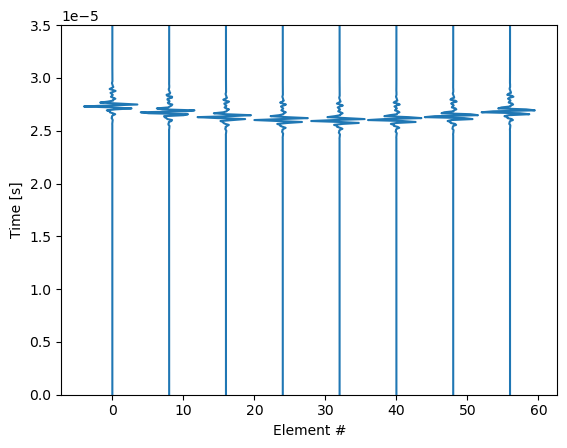

In [4]:
# Parabolic profile cannot be seen in a phase array, when reducing the element

param = pymust.getparam('P4-2v')
param.c = 1540
param.atenuation = 0.5 
# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0, .0e-2])
zScatterers = np.array([1e-2, 2e-2 ])
RCScatterers = np.array([0, 1])

# Define the activation delays for a linear wave with tilt 0
activationDelaysTX = pymust.txdelayPlane(param, 0)

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param);
ts = np.arange(RF.shape[0]) /param.fs
stride = 8
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts, c = '#1f77b4')
plt.ylim(0,3.5e-5)
plt.ylabel('Time [s]')
plt.xlabel('Element #')
plt.xlabel('Element #')

In [5]:
import scipy, scipy.io, numpy as np, matplotlib.pyplot as plt

# Part 2: Image reconstruction

Here we will understand how to reconstruct an image from the radiofrequency signals. To do this, we will define a pixel grid covering a section of the space, similar to for the pfield computation. For each pixel, we will search in the recieved radiofrequency, how much energy has been received in the timing associated to that specific pixel, which varies depending on the element (the hyperbolic profile). This done using the **Delay-And-Sum (DAS) matrix**, which we will see in more detail in the next part of this session. For now, we just need to call the code.

Note: In this section, the computations can take longer. Remember to set the option.dBThresh (as in the previous practice) to -1 if you need to reduce the computation time, at the cost of obtaining worse reconstructions

In [6]:
def reconstruct(IQ, param, txdelay, xPixelGrid, zPixelGrid):
    # You can use this function to reconstruct the image.
    M = pymust.dasmtx(IQ, xPixelGrid, zPixelGrid, txdelay, param)
    return pymust.utils.applyDasMTX(M, IQ, xPixelGrid.shape)

In [7]:
data = np.load('scatters_p3.npz')
xs = data['xScatters']
zs = data['zScatters']
RC = data['RC']

#If computational time is too long
if False:
    xs = xs[:1000]
    zs = zs[:1000]
    RC = RC[:1000]

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_88737/2726264763.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xs,zs, RC, cmap = 'jet')


Text(0, 0.5, 'Z [cm]')

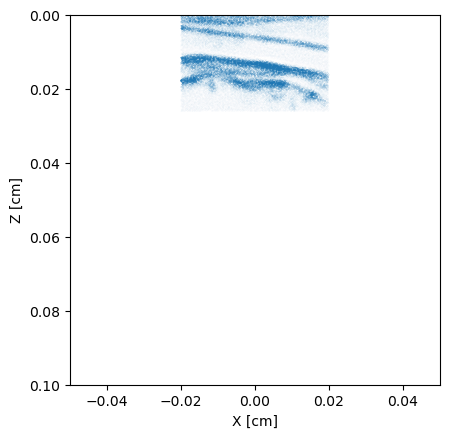

In [8]:
plt.scatter(xs,zs, RC, cmap = 'jet')
plt.gca().set_aspect('equal', 'box')
plt.ylim(0.1, 0)
plt.xlim(-0.05, 0.05)

plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')


In [11]:
#Load the data on the scatter
data = np.load('scatters_p3.npz')
xs,zs = data['xScatters'], data['zScatters']
RC = data['RC']

# Define the probe parameters, and the attenuation
param = pymust.getparam('P4-2v')
param.attenuation = 0.5

# Define the activation delays for a linear wave with tilt 0
txdelay =pymust.txdelayPlane(param, 0)

# Simulate the RF signal
RF, _ = pymust.simus(xs, zs, RC,txdelay,  param) 

# Demodulate and apply time gain compensation
IQ = pymust.rf2iq(RF, param)
IQ_tgc, _ = pymust.tgc(IQ)

# Beamforming
x_extent = np.linspace(-2.5e-2,2.5e-2,200)
z_extent = np.linspace(0,10e-2,200)
xPixelGrid,zPixelGrid = np.meshgrid(x_extent, z_extent)
M = pymust.dasmtx(IQ, xPixelGrid, zPixelGrid, txdelay, param)
IQb = pymust.utils.applyDasMTX(M, IQ, xPixelGrid.shape)

# Log-compression
I = pymust.bmode(IQb)

In [12]:
opt = pymust.utils.Options()
opt.dBThresh = -6

param.attenuation = 0.5
param.bandwidth = 76
#param.attenuation = 0.

# Simulate the response of a plane wave with tilt 0
txdelay =pymust.txdelayFocused(param, 0.015, 0.035)
txdelay =pymust.txdelayPlane(param, 0)
RF, _ = pymust.simus(xs, zs, RC,txdelay,  param, opt) # Remove the opt if it fails
IQ = pymust.rf2iq(RF, param)
IQ_tgc, _ = pymust.tgc(IQ) # FYI: You can also use the tgc on the IQ data

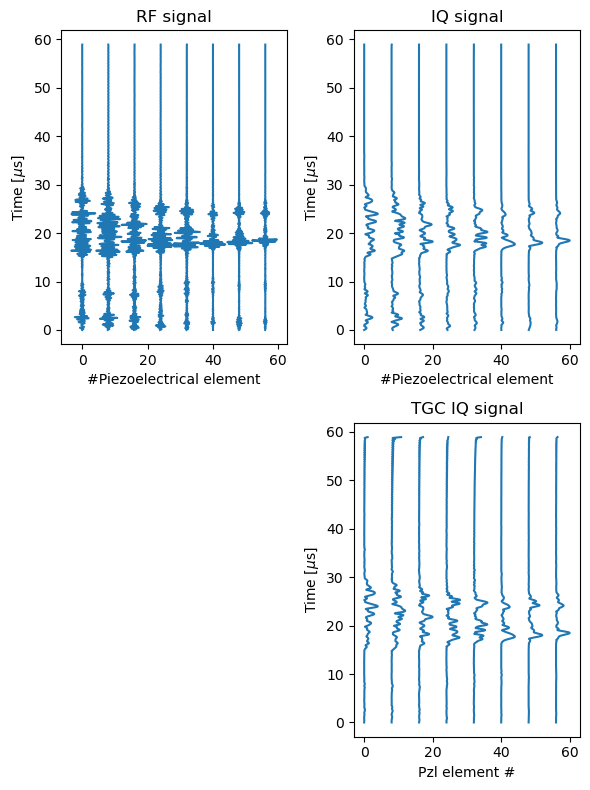

In [13]:
_, ((f0,f1),(f2,f3)) = plt.subplots(ncols =2, nrows=2, figsize = (6,8))
plt.sca(f0)
ts = np.arange(RF.shape[0]) /param.fs *1e6
stride = 8
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts, c = '#1f77b4')
plt.ylabel('Time [$\mu$s]')
plt.xlabel('#Piezoelectrical element')
plt.title('RF signal')
plt.sca(f1)
stride = 8
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*np.abs(IQ[:,idx])/np.max(np.abs(IQ[:,idx])), ts, c = '#1f77b4')
plt.ylabel('Time [$\mu$s]')
plt.xlabel('#Piezoelectrical element')
plt.title('IQ signal')

plt.sca(f2)
plt.axis('off')
plt.sca(f3)
stride = 8
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*np.abs(IQ_tgc[:,idx])/np.max(np.abs(IQ_tgc[:,idx])), ts, c = '#1f77b4')
plt.ylabel('Time [$\mu$s]')
plt.xlabel('#Piezoelectrical element')
plt.xlabel('Pzl element #')
plt.title('TGC IQ signal')

plt.tight_layout()

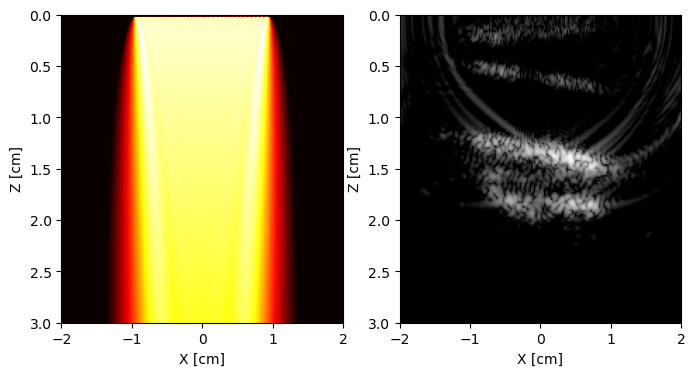

In [14]:
x_extent = np.linspace(-2e-2,2e-2,200)
z_extent = np.linspace(0,3e-2,200)
xPixelGrid,zPixelGrid = np.meshgrid(x_extent, z_extent)

image_rec = reconstruct(IQ, param, txdelay, xPixelGrid, zPixelGrid)
_, (f1, f2) = plt.subplots(ncols =2, figsize = (8, 4))
plt.sca(f2)
plt.imshow(pymust.bmode(image_rec), cmap = 'gray', extent=[x_extent[0]*1e2,x_extent[-1]*1e2,z_extent[-1]*1e2,z_extent[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')

P, _, _ = pymust.pfield(xPixelGrid, [], zPixelGrid, txdelay, param)
plt.sca(f1)
plt.imshow(20*np.log10(P/np.max(P)),cmap='hot', extent=[x_extent[0]*1e2,x_extent[-1]*1e2,z_extent[-1]*1e2,z_extent[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.clim(-20, 0)

In [ ]:
plt.imshow(pymust.bmode(image_rec), cmap = 'gray', extent=[x_extent[0]*1e2,x_extent[-1]*1e2,z_extent[-1]*1e2,z_extent[0]*1e2],aspect='auto')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.ylim(7.5, 0)
plt.gca().set_aspect('equal', 'box')

In [42]:
IQ_tgc, _ = pymust.tgc(IQ) # FYI: You can also use the tgc on the IQ data

In [ ]:
ts = np.arange(RF.shape[0]) /param.fs
stride = 8 # Plot every 8th element
elementsToShow = np.arange(0, param.Nelements, stride)
for i, idx in enumerate(elementsToShow):
    plt.plot(idx + stride/2*RF[:,idx]/np.max(np.abs(RF[:,idx])), ts *1e6, c = '#1f77b4')
plt.ylabel('Time [$\mu$s]')
plt.xlabel('Element #')
plt.xlabel('Element #')
plt.title('Received signal')



In [ ]:
yGrid = []

_, (f1, f2) = plt.subplots(ncols = 2, figsize = (12, 6))

plt.sca(f1)
x_extent = np.linspace(-2.5e-2,2.5e-2,200)
z_extent = np.linspace(0,10e-2,200)
xPixelGrid,zPixelGrid = np.meshgrid(x_extent, z_extent)

image_rec = reconstruct(IQ, param, txdelay, xPixelGrid, zPixelGrid)
plt.imshow(np.abs(image_rec), cmap = 'gray', extent=[x_extent[0]*1e2,x_extent[-1]*1e2,z_extent[-1]*1e2,z_extent[0]*1e2],aspect='auto')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
xElem, yElem, zElem, _ = param.getElementPositions()
# Plot the position of the probe
for xx, yy in zip(xElem, zElem):
    plt.scatter(xx*1e2, yy*1e2, c = 'r', s = 10)

plt.sca(f2) # Plot here the image with the log-compression 
image_rec = pymust.bmode(image_rec) # Uncomment this line to add the b-mode (log-compression)
plt.imshow(image_rec, cmap = 'gray', extent=[x_extent[0]*1e2,x_extent[-1]*1e2,z_extent[-1]*1e2,z_extent[0]*1e2],aspect='auto')


**Exercise 3.2:**
1. Run the code to generate the B-mode image, and display it with and without log-compression. Comment on the differences between with and without log-compression.
1. Plot the histograms of the image intensities before and after B-mode log compression. What do you observe? Comment also on the visual appearance of the two images.
1. You will see some circular profiles after the log-compression. These artefacts were also before log-compression, but not visible due to the scale. Why do you think they appear? 
1. Repeat the previous B-mode with log-compression, adding attenuation (0.5dB/Hz), and time-gain-compensation. Compare the three figures (without attenuation, with attenuation but no time-gain-compensation, and with both attenuation and compensation).

Hint: To plot an histogram, you can use the matplotlib "hist" function. Remember that it requires a 1D array, not an image (2D array), as an argument. You can use the image.flatten() to convert a matrix to a vector.

Now, we will see how the emitted wave and probe parameters affects the reconstructed image, especially its resolution.

**Exercise 3.3:**
1. Show in a multiplot the pfield, and the reconstructed image of a linear wave with an orientation of 20 degrees, and the pfield and reconstructed image of a focused wave in 2 different points (the focused waves are in different acquisition, you will need to plot 3 pressure fields). Comment on the relation between the regions of the B-mode that are visible, and the areas of the pfield which have higher decibels. Why does it happen?
1. Modify the number of elements of the probe to a half, and display the images. What do you observe?
1. Modify the size of the probe to a half, and to a double and display the images for both cases. What do you observe?
1. Modify the bandwidth to 20%, and display the images. What do you observe?

*Hint:* You can use the given functions to scale the probe.
